Authors: Allard Marc-Antoine

Course: FIN-407

---

## Sentiment Analysis Benchmark

1. Exploration of the training set


2. Models training:
    1. Word2Vec Embed x GloVe + Classification Algo
    3. LSTM/GRU
    4. RoBERTa
    5. FinBERT


---
### Import

In [1]:
# For Colab
# !pip instal requirements.txt
# !pip install tensorflow

In [2]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import Dataset
import pandas as pd
pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = 'matplotlib'
pd.set_option("display.max_colwidth", 200) 

import plotly.express as px
import numpy as np
from tqdm import tqdm
import statsmodels as sm 
import seaborn as sns 
from sklearn import svm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
%matplotlib inline 

from datasets import load_dataset
import spacy, nltk, gensim, sklearn, re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import * 
from spacy.lang.en import STOP_WORDS

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 

from wordcloud import WordCloud

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

glove_path = "../../data/glove.6B.100d.txt"

---
### Helper func

In [3]:
# ================================================================================================ #
def plot_timeseries(df): 
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract the year and month from the Date column
    df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)

    # Group by YearMonth and count the number of articles for each sentiment label
    monthly_counts = df.groupby(['YearMonth', 'label']).size().reset_index(name='Count')

    # Create a bar plot using Plotly Express with hue for the sentiment label
    fig = px.bar(monthly_counts, 
                 x='YearMonth', 
                 y='Count', 
                 title='Monthly Count of Sentiment-Labeled News Articles', 
                 color='label', 
                 color_discrete_map={'-1': 'red', '0': 'blue', '1': 'green'},
                 labels={'YearMonth': 'Month', 'Count': 'Number of Articles'},
                 category_orders={'label': ['-1', '0', '1']})

    # Update the x-axis tick format and angle for better readability
    fig.update_xaxes(tickangle=-45)

    # Show the plot
    fig.show()

# ================================================================================================ #
def split_hf(dataset, split_ratio=0.1, seed=42):
    split_idx = int(len(dataset) * split_ratio)
    dataset = dataset.shuffle(seed=seed)
    return {'train': dataset.select(range(split_idx, len(dataset))), 'eval': dataset.select(range(split_idx))}


# ================================================================================================ #
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# ================================================================================================ #
def grid_CV(X_train, X_test, y_train, y_test, k=3, undersampling=False):
    "Grid CV methods"

    if undersampling:
        rus = RandomUnderSampler(sampling_strategy={0: 814, 1: 814, 2: 814}, random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    
    # Prepare models and params
    model_params = {
        'Logistic Regression': {
            'model': LogisticRegression(solver='saga', max_iter=1000, random_state=42),
            'params': {
                'penalty': ['elasticnet'],
                'C': [0.01, 0.1, 0.2, 0.5, 1, 5],
                'l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0]
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [10, 50, 100, 200],
                'max_depth': [None, 10, 20, 30],
            }
        },
        'SVM': {
            'model': SVC(),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            }
        },
        'XGBOOST': {
            'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
            'params': {
                'max_depth': [5, 10, 100],
                'learning_rate': [0.01, 0.1, 0.2],
                'n_estimators': [20, 100, 200]
            }
        }
    }

    # Grid Search with CV
    best_models = {}
    results = []

    for model_name, mp in model_params.items():
        print(f"Training {model_name}...")
        clf = GridSearchCV(mp['model'], mp['params'], cv=k, scoring='f1_weighted', n_jobs=-1, verbose=1)
        clf.fit(X_train, y_train)
        
        best_models[model_name] = clf.best_estimator_
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        result = {
            'Model': model_name,
            'Best Params': clf.best_params_,
            'Test Accuracy': accuracy,
            'Test F1 Score': f1
        }
        results.append(result)
        
        print(f"{model_name} Best Params: {clf.best_params_}")
        print(f"{model_name} Accuracy: {accuracy}")
        print(f"{model_name} F1 Score: {f1}")
        print("===============================")

    # Display results in a structured format
    for result in results:
        print(f"Model: {result['Model']}")
        print(f"Best Params: {result['Best Params']}")
        print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
        print(f"Test F1 Score: {result['Test F1 Score']:.4f}")
        print("===============================")
    
    return results, best_models

# ================================================================================================ #
def show_confusion(results, best_models, X_test, y_test, unique_labels):
    # Results
    best_model_name = max(results, key=lambda x: x['Test F1 Score'])['Model']
    best_model = best_models[best_model_name]

    print(f"Best Model: {best_model_name}")
    print(f"Best Params: {best_model.get_params()}")

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"F1 test {f1_score(y_test, y_pred, average='weighted')}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.show()

# ================================================================================================ #
def show_labels_count(df):
    fig = df.labels.value_counts().plot(kind='bar', backend='plotly')

    fig.update_layout(
        xaxis_title='Count',
        yaxis_title='Number of Articles',
    )

    fig.show()

# ================================================================================================ #
def avg_word_vectors(tokens, model, vector_size):
        word_vectors = []
        for word in tokens:
            if word in model.wv:
                word_vectors.append(model.wv[word])
        if not word_vectors:
            return np.zeros(vector_size)
        return np.mean(word_vectors, axis=0)

def get_average_embedding(tokens, embeddings_index, embedding_dim):
    valid_embeddings = [embeddings_index[word] for word in tokens if word in embeddings_index]
    if not valid_embeddings:
        return np.zeros(embedding_dim)
    return np.mean(valid_embeddings, axis=0)

def load_glove_embeddings(file_path):
    " Load embeddings "
        
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# ================================================================================================ #
def get_train_eval_test(train_path, test_path, global_path="../../data/news/"):
    raw_ds = load_dataset('json', data_files={'train': global_path+train_path, 'test': global_path+test_path})
    raw_ds.update(split_hf(raw_ds['train']))
    raw_ds = raw_ds.map(lambda ex: {'labels': int(ex['label']) + 1})
    raw_ds = raw_ds.rename_columns({'summary': 'text'}).select_columns(['text', 'labels'])

    # split a return dataframes
    train_df, eval_df, test_df = raw_ds['train'].to_pandas(), raw_ds['eval'].to_pandas(), raw_ds['test'].to_pandas()

    return train_df, eval_df, test_df

# ================================================================================================ #
def full_pipeline_w2v_glove(train, eval, test):
    LAST_TRAINING_NEWS_ID = len(train)
    LAST_EVAL_NEWS_ID = LAST_TRAINING_NEWS_ID + len(eval)

    # Combine 
    full_dataset = pd.concat([train, eval, test], ignore_index=True)

    # remove unwanted char
    full_dataset['proc_summary'] = np.vectorize(remove_pattern)(full_dataset['text'], "(@[\w]*)") 

    # Replace matched characters with a space
    full_dataset.proc_summary = full_dataset.proc_summary.apply(
        lambda text: re.sub(r"[^\w]", " ", text)
    )
    # Remove stop words
    english_stopwords = STOP_WORDS  
    full_dataset.proc_summary = full_dataset.proc_summary.apply(
        lambda text: " ".join(word for word in text.split() if word not in english_stopwords)
    )
    # Tokenize and Normalize
    full_dataset['tokens'] = full_dataset['proc_summary'].apply(word_tokenize)

    # Join back
    full_dataset['proc_summary'] = full_dataset['tokens'].apply(lambda x: ' '.join(x))

    # Display Word Cloud 
    all_words = ' '.join([text for text in full_dataset['proc_summary']]) 
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
    plt.figure(figsize=(10, 7)) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis('off')
    plt.show()
    
    print()
    print('====== W2V embeddings Construction ======')
    # Construct word2vec embeddings
    model_w2v = gensim.models.Word2Vec(
            full_dataset['tokens'],
            window=8, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
    ) 

    model_w2v.train(full_dataset['tokens'], total_examples=len(full_dataset['proc_summary']), epochs=20)
    print()
    print('====== DONE ======')

    # Apply the function to create embeddings for each summary
    full_dataset['embeddings'] = full_dataset['tokens'].apply(lambda x: avg_word_vectors(x, model_w2v, 100))

    print()
    print('====== GloVe embeddings Construction ======')

    embeddings_index = load_glove_embeddings(glove_path)
    embedding_dim = 100

    # Get embeddings
    full_dataset['glove_embeddings'] = full_dataset['tokens'].apply(lambda x: get_average_embedding(x, embeddings_index, embedding_dim))
    print()
    print('====== DONE ======')

    train_w2v = full_dataset.iloc[:LAST_TRAINING_NEWS_ID,:][['glove_embeddings', 'embeddings', 'labels']]
    eval_w2v = full_dataset.iloc[LAST_TRAINING_NEWS_ID:LAST_EVAL_NEWS_ID,:][['glove_embeddings', 'embeddings', 'labels']]
    test_w2v = full_dataset.iloc[LAST_EVAL_NEWS_ID:,:][['glove_embeddings', 'embeddings', 'labels']]

    return train_w2v, eval_w2v, test_w2v

def cv_pipeline(X_train, X_test, y_train, y_test):
    # Convert labels to non-negative integers if needed
    unique_labels = np.unique(y_train)
    label_map = {label: i for i, label in enumerate(unique_labels)}
    y_train = np.array([label_map[label] for label in y_train])
    y_test = np.array([label_map[label] for label in y_test])

    # CV
    results_w2v, best_models = grid_CV(X_train, X_test, y_train, y_test, k=3)

    # confusion map
    show_confusion(results_w2v, best_models, X_test, y_test, unique_labels)

    return best_models, results_w2v


---
### Exploration of the training set

#### 1. Raw training set

In [17]:
# Get Raws dataset
train_raw_df, eval_raw_df, test_raw_df = get_train_eval_test('news_train.jsonl', 'news_test_upsample.jsonl')
show_labels_count(train_raw_df)
show_labels_count(eval_raw_df)
show_labels_count(test_raw_df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3538 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/393 [00:00<?, ? examples/s]

#### 2. Upsampled training set

In [18]:
# Get Raws dataset
train_up_df, eval_up_df, test_up_df = get_train_eval_test('news_train_upsample.jsonl', 'news_test_upsample.jsonl')
show_labels_count(train_up_df)
show_labels_count(eval_up_df)
show_labels_count(test_up_df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

#### 3. Dowsampled training set

In [19]:
# Get Raws dataset
train_down_df, eval_down_df, test_down_df = get_train_eval_test('news_train_downsample.jsonl', 'news_test_upsample.jsonl')
show_labels_count(train_down_df)
show_labels_count(eval_down_df)
show_labels_count(test_down_df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2198 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

---
### Testing set

In [45]:
testing_path = "../../data/news/"
# Load the data
testing_news = pd.read_json(testing_path+"news_eval.jsonl", lines=True)

# Add unique identifier
testing_news['id'] = range(1, len(testing_news) + 1)
# label to float
testing_news['label'] = testing_news['label'].astype(float)
# testing_news['Date'] = pd.to_datetime(testing_news['Date'])

testing_news.set_index('id', inplace=True)

testing_news.head()

,summary,label
id,,
1,"But Knot warned individual investors against joining the recent rallies in companies such as GameStop GME.N. Adds remark on interest rates and economic outlook AMSTERDAM, Jan 31 (Reuters) - The co...",0.0
2,"Western Asset/Claymore U.S. Treasury Inflation Prot Secs Fd (WIA) will begin trading ex-dividend on January 21, 2021. Shareholders who purchased WIA prior to the ex-dividend date are eligible for ...",0.0
3,"3M Co MMM.N, which makes N95 face masks and Post-it notes, added 1.5% after it reported a higher quarterly profit helped by an increase in demand for its healthcare products during the pandemic. G...",0.0
4,"A 123k fall in nonfarm payrolls in December, according to the ADP failed to spook the markets ahead of the official government figures. Eurozone unemployment, retail sales, trade data, and inflati...",0.0
5,Himax Technologies The stock of Himax Technologies (NASDAQ: HIMX) has rallied as demand for the company's display drivers has rebounded. With investors looking for long-term growth and protection ...,0.0


In [46]:
fig = testing_news.label.value_counts().plot(kind='bar', backend='plotly')

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Number of Articles',
)

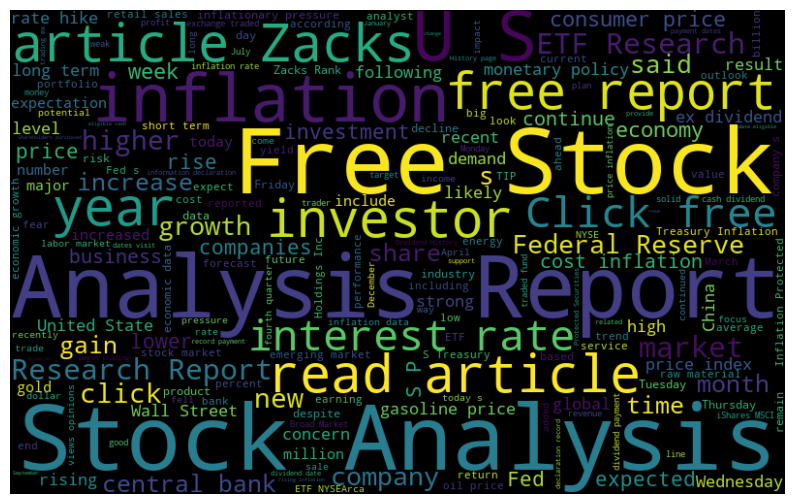


====== W2V embeddings Construction ======

====== DONE ======

====== GloVe embeddings Construction ======

====== DONE ======


In [49]:
testing_news.rename(columns={'summary': 'text'}, inplace=True)
trainxx, evalxx, test_r = full_pipeline_w2v_glove(train=train_raw_df, eval=eval_raw_df, test=testing_news)

In [51]:
test_r

,glove_embeddings,embeddings,labels
3931,"[0.02914932, 0.17243885, 0.20542307, -0.04582175, -0.01310028, -0.5080898, -0.4422564, -0.06040344, -0.060666893, -0.1663917, -0.18052498, 0.09436946, 0.1370036, -0.23087569, 0.054122657, -0.04010...","[-0.068635106, -0.33184114, 0.2715306, -0.034932915, -0.030298779, 0.122339144, 0.32374346, -0.16693868, -0.04673562, 0.13172524, -0.115589544, 0.14433359, -0.016316157, 0.25339687, -0.0082805585,...",NaN
3932,"[0.13254414, 0.11171539, 0.21834613, -0.021955548, 0.115988545, -0.16626084, 0.092757724, 0.2383421, -0.24581362, -0.15372775, 0.20039205, 0.3640125, 0.19086589, 0.015921863, 0.23308693, -0.335049...","[-0.21877721, -0.060862027, -0.21255544, -0.008971816, -0.82375383, 0.2916001, 0.36743194, -0.5178347, -0.10271551, 0.25513366, -0.07379234, 0.13369885, -0.04054751, 0.28973722, 0.03302803, -0.179...",NaN
3933,"[0.048723795, 0.1135891, 0.23797333, -0.04515548, 0.0859373, -0.3968644, -0.06447594, 0.07958506, -0.18203047, -0.07150296, 0.04514642, -0.055251602, 0.049319696, -0.014101289, 0.14724855, -0.0564...","[-0.1335951, -0.15093741, 0.041580252, 0.19332686, -0.09299972, 0.21440881, 0.31643215, -0.27059746, -0.0048362007, -0.01558456, -0.010711601, 0.23249474, -0.089466594, 0.036232244, 0.013722152, -...",NaN
3934,"[-0.064429566, 0.2351131, 0.31292412, -0.13977502, -0.06030627, -0.532216, -0.28086045, -0.11972582, 0.047624506, -0.12435458, -0.021170253, -0.15676332, 0.2150649, -0.12512021, 0.20353302, 0.2202...","[-0.11638258, -0.27872133, -0.10922691, 0.23731156, -0.24725848, 0.019543283, 0.32331845, -0.11509724, 0.2880675, -0.14939104, -0.09186907, -0.069712624, -0.10670414, 0.3984892, -0.05958069, -0.12...",NaN
3935,"[-0.0040301955, 0.2631422, 0.23469655, 0.03938913, 0.12530868, -0.5138255, -0.2989158, -0.07316647, -0.09678108, -0.076122776, -0.06251218, -0.13060308, -0.005075184, -0.27746722, 0.088771164, -0....","[0.05503283, -0.19297528, 0.112063244, -0.07050439, -0.25168014, 0.046732344, 0.16432914, -0.32341388, 0.036166236, -0.092064604, -0.08840233, -0.013627413, -0.19807036, -0.09088675, -0.08461271, ...",NaN
...,...,...,...
4286,"[-0.0628901, 0.25363913, 0.23943916, 0.0994977, 0.0058501144, -0.5285963, -0.05708479, 0.07372373, -0.27238375, -0.17509684, 0.041215915, 0.027268603, -0.022393443, -0.074836396, 0.31004283, -0.12...","[-0.051015574, -0.13410123, -0.020936847, 0.049074117, -0.10056265, 0.044251267, 0.45595965, -0.32449484, 0.013603238, -0.00841483, -0.20017436, 0.2312048, -0.018448588, 0.3226606, -0.18511938, -0...",NaN
4287,"[-0.040983606, 0.3152991, 0.13688076, 0.07851817, -0.0018151954, -0.2690235, -0.2091347, 0.08386626, -0.15522702, -0.06888423, 0.19346638, -0.0018450164, -0.15673056, -0.08325229, 0.36826217, -0.2...","[-0.034066, -0.21769825, -0.029751949, -0.11413608, -0.24970277, 0.17250924, 0.3444592, -0.23445383, -0.08700324, 0.0026240526, -0.19665557, 0.11913509, -0.098256394, 0.12262416, -0.27393752, -0.1...",NaN
4288,"[-0.09055781, 0.2594674, 0.27897725, 0.1139025, 0.14289854, -0.16482534, -0.046344806, -0.04601265, 0.09653456, 0.020096581, 0.09879226, 0.0059259785, 0.20504141, 0.04958285, 0.13256194, -0.040677...","[0.058242783, -0.22997811, 0.031607248, -0.084371716, -0.21982995, 0.21884793, 0.23085366, -0.17192805, -0.09861956, -0.07711937, -0.040307246, -0.10841487, -0.14010239, 0.025347147, -0.09866618, ...",NaN
4289,"[-0.013744368, 0.21801734, 0.09067012, 0.06261062, -0.0010695687, -0.5229892, -0.2439206, 0.05340121, 0.019796908, -0.0944004, 0.12540199, -0.17128949, 0.20625852, -0.088757165, 0.3214787, -0.1414...","[-0.18907335, -0.1883844, 0.16783842, 0.05417096, -0.31777734, 0.06487056, 0.39362475, -0.2796795, 0.0029726238, -0.10067038, -0.039581943, 0.13951905, -0.1379982, 0.1831812, -0.16142438, -0.00972...",NaN


---
### SA Benchmark

### 1. Word2Vec + Classifier

**1. Word2Vec Embeddings**

Word2Vec is not a single algorithm but a combination of two techniques – **CBOW (Continuous bag of words)** and **Skip-gram** model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

Below is a diagrammatic representation of a 1-word context window Word2Vec model.

![imgur](https://i.imgur.com/f77V0dH.png)

There are three laters: - an input layer, - a hidden layer, and - an output layer.

The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

We will go ahead with the Skip-gram model as it has the following advantages:

* It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

* Skip-gram with negative sub-sampling outperforms CBOW generally.

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using **pre-trained word vectors** instead of training our own model. Some of the freely available pre-trained vectors are:

1. [Google News Word Vectors](https://code.google.com/archive/p/word2vec/)

1. [Freebase names](https://code.google.com/archive/p/word2vec/)

1. [DBPedia vectors (wiki2vec)](https://github.com/idio/wiki2vec#prebuilt-models)

However, for now, we will train our own word vectors since size of the pre-trained word vectors is generally huge.

Let’s train a Word2Vec x GloVe model on our corpus.

#### Models testing (Word2vec VS GloVe)

#### 1. Raw training set

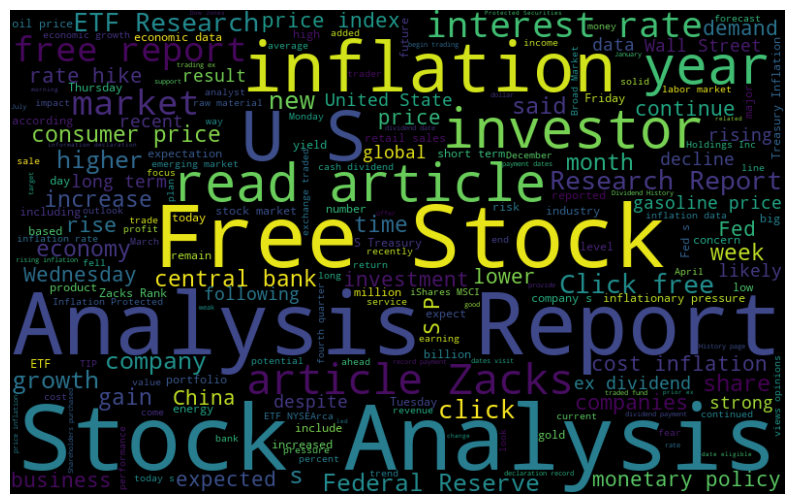


====== W2V embeddings Construction ======

====== DONE ======

====== GloVe embeddings Construction ======

====== DONE ======


In [20]:
# call pipeline
train_raw, eval_raw, test_raw = full_pipeline_w2v_glove(train=train_raw_df, eval=eval_raw_df, test=test_raw_df)

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 5, 'l1_ratio': 0.7, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.5877862595419847
Logistic Regression F1 Score: 0.5712445388586234
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': 20, 'n_estimators': 100}
Random Forest Accuracy: 0.6743002544529262
Random Forest F1 Score: 0.6581598802932832
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.6234096692111959
SVM F1 Score: 0.6176146899081107
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBOOST Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
XGBOOST Accuracy: 0.6335877862595419
XGBOOST F1 Score: 0.6303583061023199
Model: Logistic Regression
Best Params: {'C': 5, 'l1_ratio': 0

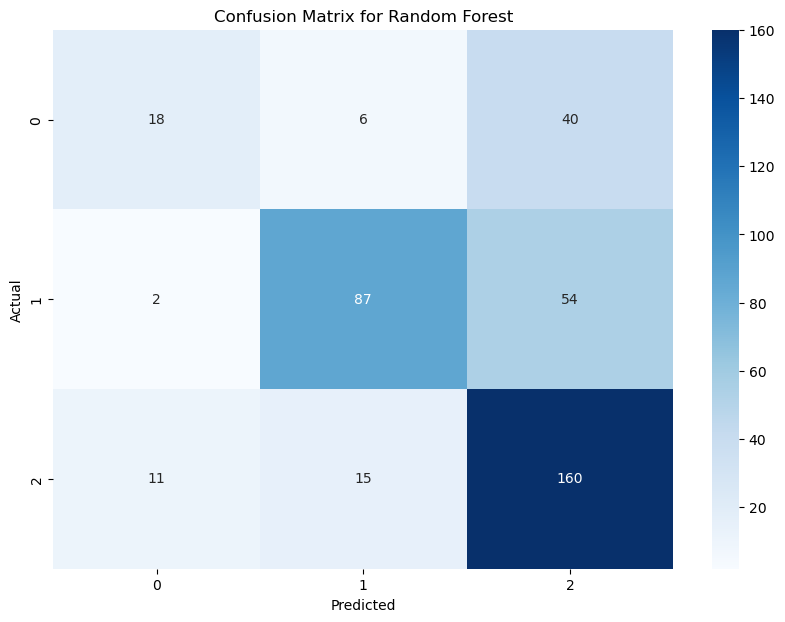

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 1, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.5903307888040712
Logistic Regression F1 Score: 0.5725139400423859
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': 20, 'n_estimators': 200}
Random Forest Accuracy: 0.6437659033078881
Random Forest F1 Score: 0.6204356118104218
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.5877862595419847
SVM F1 Score: 0.5621974873822445
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



XGBOOST Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
XGBOOST Accuracy: 0.648854961832061
XGBOOST F1 Score: 0.6394099342558694
Model: Logistic Regression
Best Params: {'C': 1, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Test Accuracy: 0.5903
Test F1 Score: 0.5725
Model: Random Forest
Best Params: {'max_depth': 20, 'n_estimators': 200}
Test Accuracy: 0.6438
Test F1 Score: 0.6204
Model: SVM
Best Params: {'C': 10, 'kernel': 'poly'}
Test Accuracy: 0.5878
Test F1 Score: 0.5622
Model: XGBOOST
Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Test Accuracy: 0.6489
Test F1 Score: 0.6394
Best Model: XGBOOST
Best Params: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'im

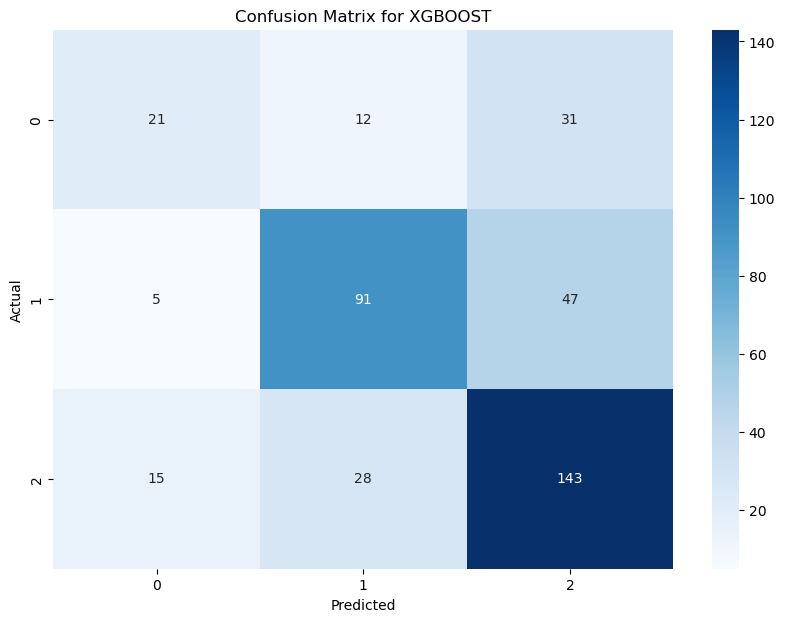

In [21]:
# Word2Vec
X_train_raw = train_raw['embeddings'].tolist()
X_eval_raw = eval_raw['embeddings'].tolist()
y_train_raw = train_raw['labels'].tolist()
y_eval_raw = eval_raw['labels'].tolist()

best_models_w2v, results_w2v = cv_pipeline(X_train_raw, X_eval_raw, y_train_raw, y_eval_raw)

# GloVe
X_train_raw = train_raw['glove_embeddings'].tolist()
X_eval_raw = eval_raw['glove_embeddings'].tolist()
y_train_raw = train_raw['labels'].tolist()
y_eval_raw = eval_raw['labels'].tolist()

best_models_glove, results_glove = cv_pipeline(X_train_raw, X_eval_raw, y_train_raw, y_eval_raw)

#### 2. Upsampled training set

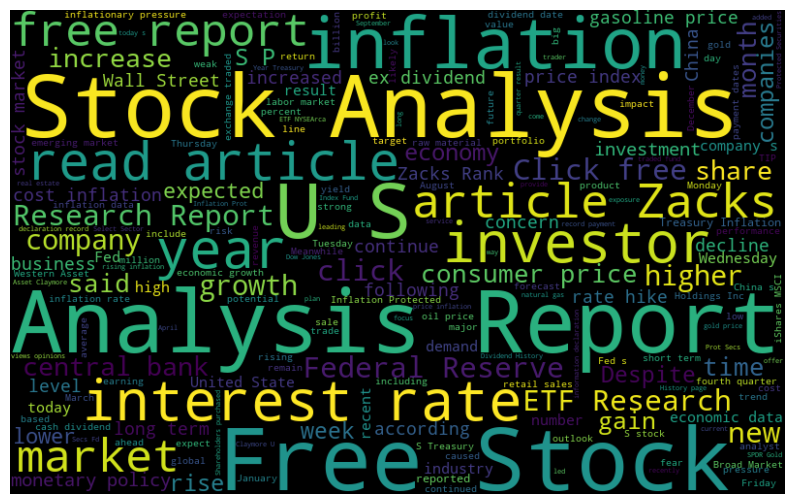


====== W2V embeddings Construction ======

====== DONE ======

====== GloVe embeddings Construction ======

====== DONE ======


In [22]:
# call pipeline
train_up, eval_up, test_up = full_pipeline_w2v_glove(train=train_up_df, eval=eval_up_df, test=test_up_df)

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 0.5, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.57
Logistic Regression F1 Score: 0.5693911517639242
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': None, 'n_estimators': 200}
Random Forest Accuracy: 0.7416666666666667
Random Forest F1 Score: 0.7426776044128142
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.7216666666666667
SVM F1 Score: 0.7227189955169437
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBOOST Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
XGBOOST Accuracy: 0.72
XGBOOST F1 Score: 0.7210466425970572
Model: Logistic Regression
Best Params: {'C': 0.5, 'l1_ratio': 0.0, 'penalty': 'elasti

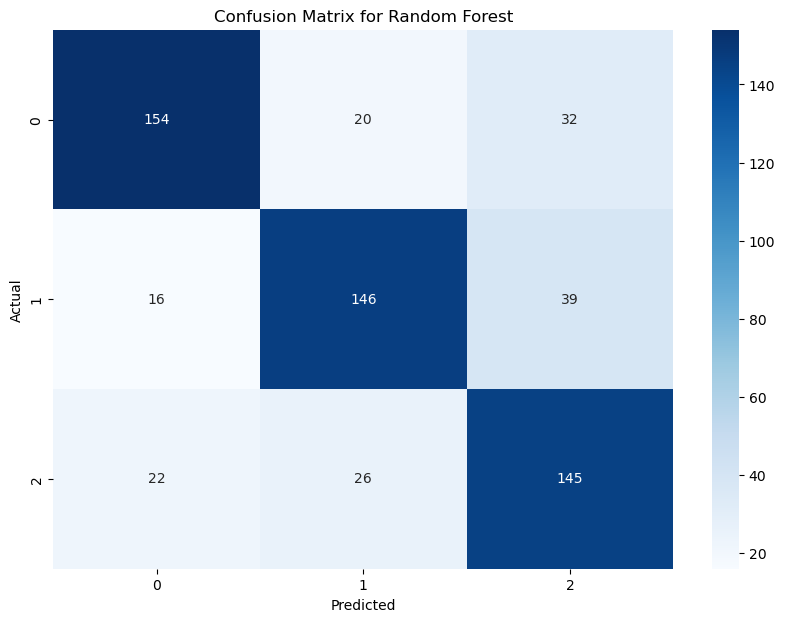

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 0.5, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.5383333333333333
Logistic Regression F1 Score: 0.5377485958267199
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': None, 'n_estimators': 200}
Random Forest Accuracy: 0.6966666666666667
Random Forest F1 Score: 0.697533706963565
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.6366666666666667
SVM F1 Score: 0.6370476744011075
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



XGBOOST Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
XGBOOST Accuracy: 0.6933333333333334
XGBOOST F1 Score: 0.6930833407288697
Model: Logistic Regression
Best Params: {'C': 0.5, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Test Accuracy: 0.5383
Test F1 Score: 0.5377
Model: Random Forest
Best Params: {'max_depth': None, 'n_estimators': 200}
Test Accuracy: 0.6967
Test F1 Score: 0.6975
Model: SVM
Best Params: {'C': 10, 'kernel': 'poly'}
Test Accuracy: 0.6367
Test F1 Score: 0.6370
Model: XGBOOST
Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Test Accuracy: 0.6933
Test F1 Score: 0.6931
Best Model: Random Forest
Best Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob

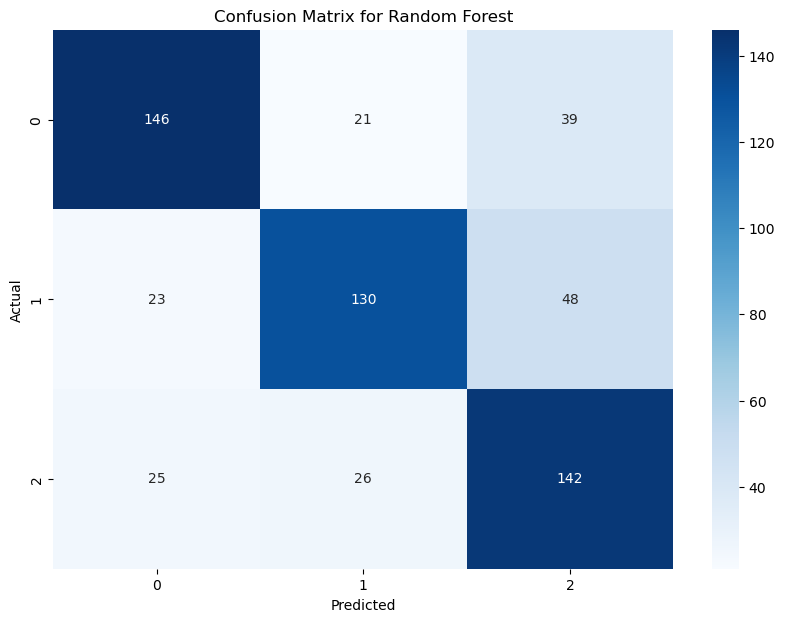

In [23]:
# Word2Vec
X_train_up = train_up['embeddings'].tolist()
X_eval_up = eval_up['embeddings'].tolist()
y_train_up = train_up['labels'].tolist()
y_eval_up = eval_up['labels'].tolist()

best_models_w2v_up, results_w2v_up = cv_pipeline(X_train_up, X_eval_up, y_train_up, y_eval_up)

# GloVe
X_train_up = train_up['glove_embeddings'].tolist()
X_eval_up = eval_up['glove_embeddings'].tolist()
y_train_up = train_up['labels'].tolist()
y_eval_up = eval_up['labels'].tolist()

best_models_glove_up, results_glove_up = cv_pipeline(X_train_up, X_eval_up, y_train_up, y_eval_up)

#### 3. Downsampled training set

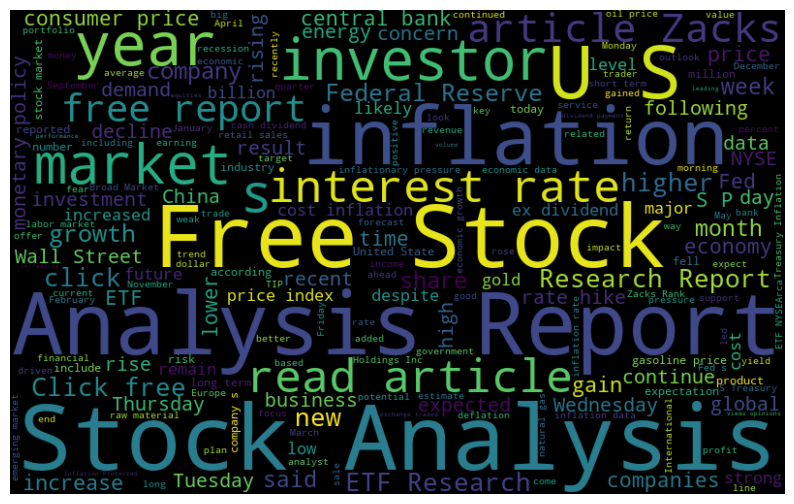


====== W2V embeddings Construction ======

====== DONE ======

====== GloVe embeddings Construction ======

====== DONE ======


In [24]:
# call pipeline
train_down, eval_down, test_down = full_pipeline_w2v_glove(train=train_down_df, eval=eval_down_df, test=test_down_df)

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.4959016393442623
Logistic Regression F1 Score: 0.49250326068763406
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': 30, 'n_estimators': 200}
Random Forest Accuracy: 0.5983606557377049
Random Forest F1 Score: 0.598417532416107
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best Params: {'C': 10, 'kernel': 'poly'}
SVM Accuracy: 0.5655737704918032
SVM F1 Score: 0.5654230745204535
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBOOST Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
XGBOOST Accuracy: 0.5901639344262295
XGBOOST F1 Score: 0.5888197637379385
Model: Logistic Regression
Best Params: {'C': 1, 'l1_ratio': 

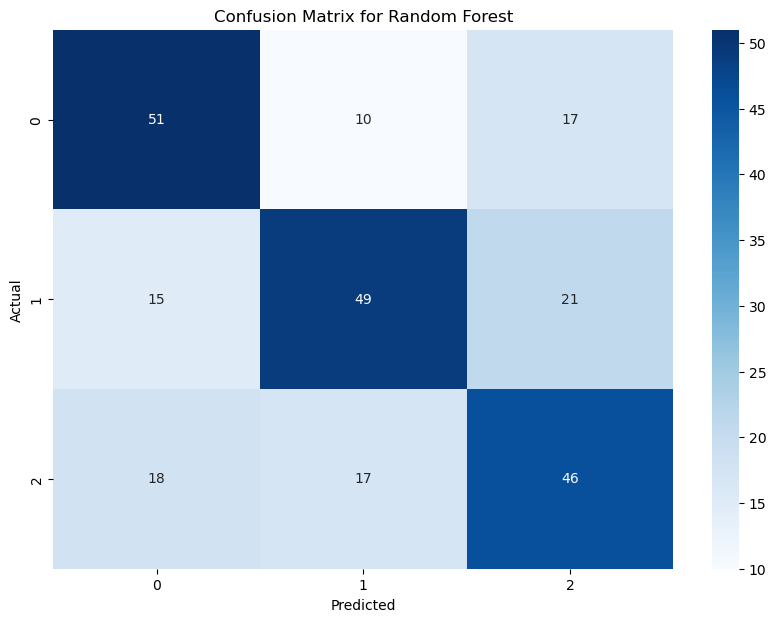

Training Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Logistic Regression Best Params: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Logistic Regression Accuracy: 0.5532786885245902
Logistic Regression F1 Score: 0.5529077003520245
Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest Best Params: {'max_depth': 20, 'n_estimators': 200}
Random Forest Accuracy: 0.569672131147541
Random Forest F1 Score: 0.5721370233268699
Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



SVM Best Params: {'C': 10, 'kernel': 'rbf'}
SVM Accuracy: 0.5655737704918032
SVM F1 Score: 0.5656723243598674
Training XGBOOST...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



XGBOOST Best Params: {'learning_rate': 0.1, 'max_depth': 100, 'n_estimators': 200}
XGBOOST Accuracy: 0.5778688524590164
XGBOOST F1 Score: 0.5780163890508361
Model: Logistic Regression
Best Params: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Test Accuracy: 0.5533
Test F1 Score: 0.5529
Model: Random Forest
Best Params: {'max_depth': 20, 'n_estimators': 200}
Test Accuracy: 0.5697
Test F1 Score: 0.5721
Model: SVM
Best Params: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.5656
Test F1 Score: 0.5657
Model: XGBOOST
Best Params: {'learning_rate': 0.1, 'max_depth': 100, 'n_estimators': 200}
Test Accuracy: 0.5779
Test F1 Score: 0.5780
Best Model: XGBOOST
Best Params: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, '

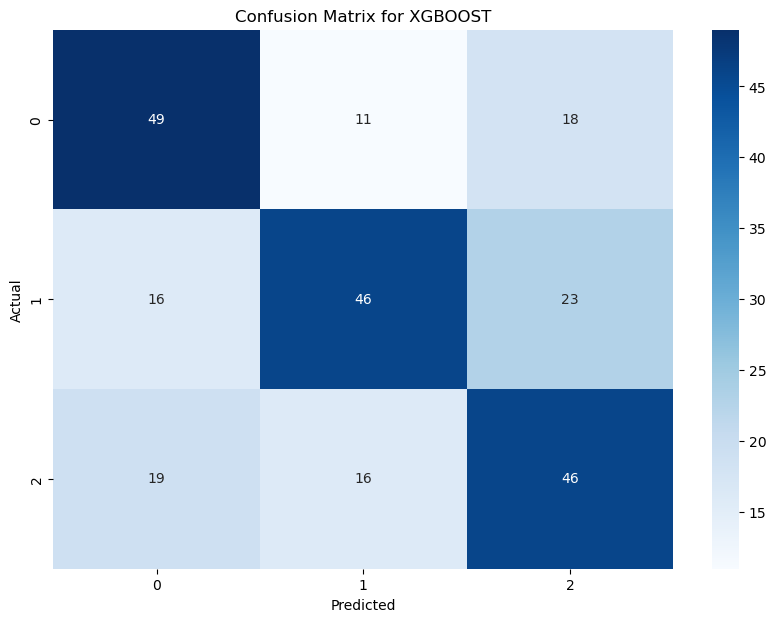

In [25]:
# Word2Vec
X_train_down = train_down['embeddings'].tolist()
X_eval_down = eval_down['embeddings'].tolist()
y_train_down = train_down['labels'].tolist()
y_eval_down = eval_down['labels'].tolist()

best_models_w2v_down, results_w2v_down = cv_pipeline(X_train_down, X_eval_down, y_train_down, y_eval_down)

# GloVe
X_train_down = train_down['glove_embeddings'].tolist()
X_eval_down = eval_down['glove_embeddings'].tolist()
y_train_down = train_down['labels'].tolist()
y_eval_down = eval_down['labels'].tolist()

best_models_glove_down, results_glove_down = cv_pipeline(X_train_down, X_eval_down, y_train_down, y_eval_down)

#### 1. Raw Test

In [54]:
# Results
best_model_name = max(results_w2v, key=lambda x: x['Test F1 Score'])['Model']
best_model = best_models_w2v[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Params: {best_model.get_params()}")

# Predict on the test set using the best model
y_pred = best_model.predict(test_raw['embeddings'].tolist())

# Generate confusion matrix
conf_matrix = confusion_matrix(test_raw['labels'].tolist(), y_pred)

print(f"F1 test {f1_score(test_raw['labels'].tolist(), y_pred, average='weighted')}")


Best Model: Random Forest
Best Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
F1 test 0.16645754914261815


#### 1. Up Test

In [59]:
# Results
best_model_name = max(results_glove_up, key=lambda x: x['Test F1 Score'])['Model']
best_model = best_models_glove_up[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Params: {best_model.get_params()}")

# Predict on the test set using the best model
y_pred = best_model.predict(test_up['glove_embeddings'].tolist())

print(f"F1 test {f1_score(test_up['labels'].tolist(), y_pred, average='weighted')}")


Best Model: Random Forest
Best Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
F1 test 0.2380939863130132


#### 1. Down Test

In [39]:
# Results
best_model_name = max(results_w2v_down, key=lambda x: x['Test F1 Score'])['Model']
best_model = best_models_w2v_down[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Params: {best_model.get_params()}")

# Predict on the test set using the best model
y_pred = best_model.predict(test_down['embeddings'].tolist())

# Generate confusion matrix
conf_matrix = confusion_matrix(test_down['labels'].tolist(), y_pred)

print(f"F1 test {f1_score(test_down['labels'].tolist(), y_pred, average='weighted')}")


Best Model: Random Forest
Best Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
F1 test 0.2639628016986508


---
### Augmented dataset

- Augmented of the umbalanced class using a T5 paraphraser

In [73]:
test_raw_df.labels.value_counts()

labels
1    171
2    121
0     68
Name: count, dtype: int64

In [74]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [76]:
# split the dataset{summary x label}
X = test_raw_df['text']
y = test_raw_df['labels']

In [78]:
# Load the T5 paraphrasing model and tokenizer
paraphrase_tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")
paraphrase_model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to('mps')

In [83]:
def paraphrase(
    question,
    num_beams=5,
    num_beam_groups=5,
    num_return_sequences=5,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=128
):
    input_ids = paraphrase_tokenizer(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids.to('mps')
    
    outputs = paraphrase_model.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = paraphrase_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return res

# Test
paraphrases = paraphrase("If you want to avoid inflation, burn some cash", num_return_sequences=1)
print(paraphrases)

['To steer clear of inflation, it is advisable to use some money.']


In [85]:
desired_count = 200

# Create a new DataFrame to store the upsampled data
upsampled_df = pd.DataFrame(columns=['text', 'labels'])

# Upsample each class
for label in y.unique():
    class_df = test_raw_df[test_raw_df['labels'] == label]
    current_count = len(class_df)

    # If current count is less than the desired count, generate additional samples
    while current_count < desired_count:
        text_to_paraphrase = class_df['text'].sample(1).iloc[0]
        paraphrase_s = paraphrase(text_to_paraphrase, num_return_sequences=1)[0]
        upsampled_df = upsampled_df._append({'text': paraphrase_s, 'labels': label}, ignore_index=True)
        print("added")
        current_count += 1
    print(f"Label {label}: DONE")
    upsampled_df = upsampled_df._append(class_df, ignore_index=True)

# Shuffle the DataFrame
upsampled_df = upsampled_df.sample(frac=1).reset_index(drop=True)

# Check the new class distribution
upsampled_df['labels'].value_counts()

added
added


KeyboardInterrupt: 

In [ ]:
upsampled_df.to_json("news_train_upsample")